In [1]:
# Import all required tools
import re
import os
import sys
import string
import codecs
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()

In [2]:
from nltk.corpus import stopwords
stop = stopwords.words('french')

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('./scenarii.csv', encoding="ISO-8859-1", sep=";", header = 0)
data.head()

,texte,tag
0,4.\tVersion Desktop - liste des cas d'utilisat...,texte
1,4.1.1\tCU001-001 Afficher le header,usecase
2,Acteur : Internaute,acteur
3,Cas dutilisation permettant à un internaute ...,texte
4,\tNotes :\nLe système affiche les éléments su...,texte


In [4]:
#Mettre le texte en Minuscule
data['texte'] = data['texte'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['texte'].head()

0    4. version desktop - liste des cas d'utilisati...
1                   4.1.1 cu001-001 afficher le header
2                                  acteur : internaute
3    cas dutilisation permettant à un internaute d...
4     notes : le système affiche les éléments suiv...
Name: texte, dtype: object

In [5]:
data['word_count'] = data['texte'].apply(lambda x: len(str(x).split(" ")))
data[['texte','word_count']].head(40)

,texte,word_count
0,4. version desktop - liste des cas d'utilisati...,15
1,4.1.1 cu001-001 afficher le header,5
2,acteur : internaute,3
3,cas dutilisation permettant à un internaute d...,39
4, notes : le système affiche les éléments suiv...,45
5, actions : si lutilisateur clique sur le log...,115
6,4.1.2 cu001-002 afficher le bouton de langue,7
7,acteur : internaute,3
8,cas dutilisation permettant à un internaute d...,12
9, notes : le système affiche : la langue sélec...,20


In [6]:
data['stopwords'] = data['texte'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['texte','stopwords']].head(20)

,texte,stopwords
0,4. version desktop - liste des cas d'utilisati...,2
1,4.1.1 cu001-001 afficher le header,1
2,acteur : internaute,0
3,cas dutilisation permettant à un internaute d...,14
4, notes : le système affiche les éléments suiv...,12
5, actions : si lutilisateur clique sur le log...,36
6,4.1.2 cu001-002 afficher le bouton de langue,2
7,acteur : internaute,0
8,cas dutilisation permettant à un internaute d...,5
9, notes : le système affiche : la langue sélec...,6


In [7]:
data['texte'] = data['texte'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['texte'].head()

0    4. version desktop - liste cas d'utilisations ...
1                      4.1.1 cu001-001 afficher header
2                                  acteur : internaute
3    cas dutilisation permettant internaute consul...
4     notes : système affiche éléments suivants : ...
Name: texte, dtype: object

In [8]:
freq = pd.Series(' '.join(data['texte']).split()).value_counts()[:20]
freq

:                1641
                1634
champ             846
système           802
affiche           735
si                664
liste             633
afficher          613
cas               603
bloc              585
dutilisation     573
page              518
texte             449
titre             446
bouton            437
date              421
clic              378
règles            353
décrivant         329
a                 328
dtype: int64

In [9]:
mfreq = pd.Series(' '.join(data['texte']).split()).value_counts()[-20:]
mfreq

4.17.5            1
4.9.10.a          1
textes            1
(plan             1
4.2.1.g           1
dappel           1
4.17.4            1
4.9.14.a          1
4.6.8.l4.6.8.j    1
022               1
4.15.2.d          1
assister          1
5.6.1.f           1
sappliquer       1
cu012-001         1
4.10              1
4.6               1
4.7.3             1
cu009-405         1
supprimés         1
dtype: int64

In [10]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [10]:
from textblob import TextBlob
TextBlob(data['texte'][0]).ngrams(2)

[WordList(['4', 'version']),
 WordList(['version', 'desktop']),
 WordList(['desktop', 'liste']),
 WordList(['liste', 'cas']),
 WordList(['cas', "d'utilisations"]),
 WordList(["d'utilisations", '4.1']),
 WordList(['4.1', 'eléments']),
 WordList(['eléments', 'transverses']),
 WordList(['transverses', 'site']),
 WordList(['site', 'lot']),
 WordList(['lot', '1'])]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,3))
data_vect = tfidf.fit_transform(data['texte'])

data_vect

<2382x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 44208 stored elements in Compressed Sparse Row format>

In [13]:
data_vect.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.54960288, 0.55846686, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_vect.toarray())

In [15]:
dbscan = DBSCAN(eps=0.003, min_samples = 2)
clusters = dbscan.fit_predict(data_scaled)

Text(0, 0.5, 'Feature 1')

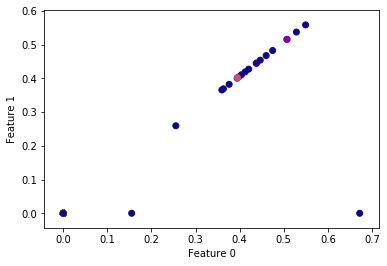

In [16]:
# plot the cluster assignments
plt.scatter(data_vect.toarray()[:, 0], data_vect.toarray()[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [17]:
#Construction d'un clustering de 5 clusters
from sklearn.cluster import MiniBatchKMeans
nbc=5
model = MiniBatchKMeans(n_clusters=nbc, random_state=0)
model.fit(data_vect)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [18]:
# Affichons les termes communs à chaque cluster
nbc = 5
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nbc):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 afficher
 clic
 actions
 page
 lot
 liste
 bouton
 bloc
 voir
 actions clic
Cluster 1:
 champ
 affiche
 système affiche
 système
 date
 notes
 texte
 titre
 oui
 affichage
Cluster 2:
 règles
 contribuer
 si
 élément
 règles gestion
 gestion
 bloc
 15
 affiche
 langue
Cluster 3:
 acteur
 acteur internaute
 internaute
 administrateur
 acteur administrateur
 administrateur contributeur
 contributeur
 favoris
 notice
 titre
Cluster 4:
 décrivant
 utilisation décrivant
 cas utilisation
 utilisation
 décrivant consultation
 cas
 consultation
 page
 consultation bloc
 décrivant contribution


In [19]:
Y = tfidf.transform(["Acteur : Internaute"])
prediction = model.predict(Y)
print(prediction)

[3]


In [20]:
Y = tfidf.transform(["4.1.2 CU001-002 Afficher le bouton de langu"])
prediction = model.predict(Y)
print(prediction)

[0]


In [21]:
Y = tfidf.transform(["Cas d’utilisation permettant à un internaute  de consulter le fil d’ariane du site."])
prediction = model.predict(Y)
print(prediction)

[0]


In [22]:
Y = tfidf.transform(["Si il y a plus de 3 jours successifs ayant les mêmes horaires, le système affiche Du [1er jour] au [dernier jour] Si il a 3 jours successifs ayant les mêmes horaires, le système affiche [1er jour], [2eme jour] et [3eme jour] Si il ya 2 jours successifs, le système affiche [1er jour], [2eme jour]"])
prediction = model.predict(Y)
print(prediction)

[1]


In [23]:
Y = tfidf.transform(["Nom du champ Type de champ obligatoire Commentaires"])
prediction = model.predict(Y)
print(prediction)

[1]


In [24]:
Y = tfidf.transform(["Nom de la langue Champ texte OUI Ge"])
prediction = model.predict(Y)
print(prediction)

[1]


In [25]:
Y = tfidf.transform(["L’utilisateur peut créer un lien de niveau 1"])
prediction = model.predict(Y)
print(prediction)

[2]


In [26]:
Y = tfidf.transform(["Pour ajouter une notice dans un panier, l’utilisateur sélectionne dispose de 2 filtres de recherche :"])
prediction = model.predict(Y)
print(prediction)

[0]


In [27]:
Y = tfidf.transform(["La langue sélectinnée"])
prediction = model.predict(Y)
print(prediction)

[2]


In [28]:
Y = tfidf.transform(["Ce bloc est visible sur toutes les pages éditoriales et tous les événements"])
prediction = model.predict(Y)
print(prediction)

[2]


In [29]:
Y = tfidf.transform(["Le système affiche les éléments suivants de la page éditoriale: un élément image, texte vidéo, twitter, son, 3D"])
prediction = model.predict(Y)
print(prediction)

[2]


In [30]:
Y = tfidf.transform(["l’utilisateur sélectionne dispose de 2 filtres de recherche :"])
prediction = model.predict(Y)
print(prediction)

[2]


In [31]:
Y = tfidf.transform(["Le système affiche le buton accès rapide avec titre, sous-titre, …"])
prediction = model.predict(Y)
print(prediction)

[1]


In [32]:
Y = tfidf.transform(["Le contributeur peut sélectionner des pages éditoriales, des événementd…"])
prediction = model.predict(Y)
print(prediction)

[2]


In [33]:
Y = tfidf.transform(["saisi l’url directe dans son navigateur"])
prediction = model.predict(Y)
print(prediction)

[0]


In [34]:
Y = tfidf.transform(["Nom du public"])
prediction = model.predict(Y)
print(prediction)

[2]


In [35]:
Y = tfidf.transform(["Visualisation du liste du footer"])
prediction = model.predict(Y)
print(prediction)

[0]


In [36]:
Y = tfidf.transform(["Type de champ obligatoire"])
prediction = model.predict(Y)
print(prediction)

[1]


In [37]:
Y = tfidf.transform(["Le menu est constitué des entrées de niveau 1"])
prediction = model.predict(Y)
print(prediction)

[2]


In [38]:
Y = tfidf.transform(["Afficher la télécommande"])
prediction = model.predict(Y)
print(prediction)

[0]


In [39]:
Y = tfidf.transform(["Modifier le footer"])
prediction = model.predict(Y)
print(prediction)

[2]


In [40]:
Y = tfidf.transform(["Afficher le footer"])
prediction = model.predict(Y)
print(prediction)

[0]


In [41]:
Y = tfidf.transform(["Le contributeur se place en mode liste sur le dossier Page d’accueil - bloc Identitaire.  Il peut :Contribuer une vidéo [...]"])
prediction = model.predict(Y)
print(prediction)

[2]


In [42]:
from sklearn.metrics import silhouette_score
silhouette_score(data_vect, labels=model.predict(data_vect))

0.11607768957426064

In [43]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(data_vect.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

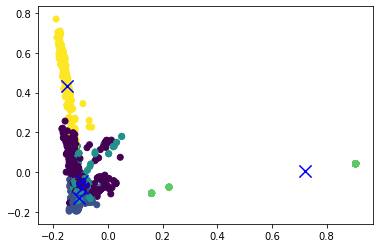

In [44]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(data_vect))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

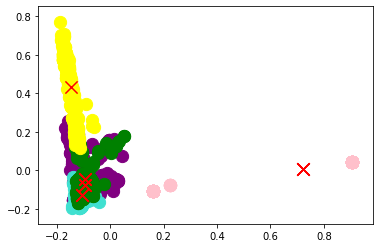

In [45]:
#ACP
from sklearn.decomposition import PCA
acp = PCA(n_components=2).fit_transform(data_vect.toarray())

plt.scatter(acp[:,0], acp[:,1], c=model.predict(data_vect))
acp_cluster_centers = pca.transform(model.cluster_centers_)
for couleur,k in zip(['purple','turquoise','green','pink','yellow'],[0,1,2,3,4]):
    plt.scatter(acp[model.labels_==k,0],acp[model.labels_==k,1],s=150,c=couleur)
    plt.scatter(acp_cluster_centers[:, 0], acp_cluster_centers[:,1], marker='x', s=150, c='red')
plt.show()

In [47]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0] 

In [48]:
ClusterIndicesNumpy(2, model.labels_) 

array([   9,   11,   16,   23,   35,   37,   38,   40,   44,   45,   47,
         55,   56,   59,   65,   66,   69,   76,   80,   84,   85,   89,
        109,  113,  116,  119,  136,  140,  141,  144,  145,  147,  148,
        149,  151,  152,  155,  158,  159,  161,  165,  167,  169,  170,
        172,  173,  180,  188,  201,  205,  206,  207,  208,  215,  220,
        221,  225,  226,  231,  234,  240,  241,  243,  248,  249,  251,
        258,  263,  264,  265,  266,  271,  277,  279,  287,  288,  291,
        292,  293,  296,  299,  300,  301,  303,  305,  306,  310,  311,
        313,  315,  316,  320,  321,  325,  326,  329,  331,  332,  334,
        335,  336,  338,  339,  341,  342,  344,  345,  349,  350,  352,
        353,  354,  357,  358,  360,  363,  367,  370,  371,  373,  392,
        396,  397,  408,  414,  419,  425,  431,  437,  443,  449,  463,
        478,  493,  508,  514,  530,  545,  547,  560,  581,  584,  589,
        590,  591,  592,  593,  594,  595,  596,  6

In [52]:
data.texte[ClusterIndicesNumpy(2, model.labels_) ]

9        notes : système affiche : langue sélectionné...
11       règles gestion : si lutilisateur clique ang...
16                4.1.4 cu001-0022 contribuer page langue
23      fil dariane présent toutes pages permet luti...
35       notes : menu constitué entrées niveau 1 : in...
37       règles gestion : si lutilisateur navigue la...
38               4.1.8 cu001-006 modifier menu navigation
40       notes : lutilisateur peut créer lien niveau...
44       règles gestion : si lutilisateur a sélectio...
45       4.1.10 cu001-008 contribuer contenu autre langue
47      cas dutilisation permettant internaute contri...
55       règles gestion : si lutilisateur ouvre nouv...
56                 4.1.12 cu001-010 modifier télécommande
59      lutilisateur peut modifier lordre daffichag...
65       règles gestion : footer saffiche pages suiv...
66                       4.1.14 cu001-012 modifier footer
69       notes : lutilisateur peut créer lien niveau...
76          4.

In [53]:
data.texte[ClusterIndicesNumpy(0, model.labels_) ]

0       4. version desktop - liste cas d'utilisations ...
1                         4.1.1 cu001-001 afficher header
3       cas dutilisation permettant internaute consul...
4        notes : système affiche éléments suivants : ...
5        actions : si lutilisateur clique logo depui...
6                  4.1.2 cu001-002 afficher bouton langue
8       cas dutilisation permettant internaute consul...
10       actions : clic langue sélectionnée, système ...
12                  4.1.3 cu001-0021 afficher page langue
14      cas dutilisation permettant internaute consul...
20                  4.1.5 cu001-003 afficher fil dariane
22      cas dutilisation permettant internaute consul...
24      fil dariane composé dun lien vers page dacc...
25       règles gestion fil dariane saffiche : page...
26                4.1.6 cu001-004 afficher bouton partage
28      cas dutilisation permettant internaute consul...
29       notes : page cours consultation partagée com...
30       acti

In [54]:
data.texte[ClusterIndicesNumpy(1, model.labels_) ]

15       notes : système affiche chaque langue ci-des...
19      nom champ type champ obligatoire commentaires ...
53       notes : système affiche 5 accès rapides suiv...
73       notes : bloc visible toutes pages éditoriale...
75       règles gestion événement saffiche bloc mome...
79      nom champ type champ obligatoire commentaires ...
83      nom champ type champ obligatoire commentaires ...
88      nom champ type champ obligatoire commentaires ...
101      notes : cette barre visible seulement page d...
103      règles gestion : sil ny a dentité informa...
107      notes : système affiche lordre suivant élém...
114      notes : système affiche entités carrousel tr...
117     champ sélectionné back-office règles dafficha...
118     date début date fin [date début] [date fin] 15...
127      notes : système affiche entités parcours déf...
132      notes : système affiche : onglets lordre cr...
134      règles gestion : onglet sil nexiste dongl...
139     nom ch

In [55]:
data.texte[ClusterIndicesNumpy(3, model.labels_) ]

2                          acteur : internaute
7                          acteur : internaute
13                         acteur : internaute
17      acteur : administrateur / contributeur
21                         acteur : internaute
27                         acteur : internaute
33                         acteur : internaute
39      acteur : administrateur / contributeur
42                         acteur : internaute
46                         acteur : internaute
51                         acteur : internaute
57      acteur : contributeur / administrateur
61                         acteur : internaute
67      acteur : administrateur / contributeur
71                         acteur : internaute
77      acteur : contributeur / administrateur
81      acteur : administrateur / contributeur
86      acteur : administrateur / contributeur
94                         acteur : internaute
99                         acteur : internaute
105                        acteur : internaute
111          

In [56]:
data.texte[ClusterIndicesNumpy(4, model.labels_) ]

18      cas dutilisation décrivant contribution page ...
52      cas dutilisation décrivant consultation téléc...
58      cas dutilisation décrivant contribution téléc...
68        cas dutilisation décrivant contribution footer
72      cas dutilisation décrivant consultation bloc ...
78      cas dutilisation décrivant contribution bloc ...
82      cas dutilisation décrivant contribution liste...
87      cas dutilisation décrivant contribution liste...
95      cas dutilisation décrivant fonctionnement pag...
100     cas dutilisation décrivant consultation dune...
126     cas dutilisation décrivant consultation parco...
138     cas dutilisation décrivant lajout dune info...
143     cas dutilisation décrivant contribution bloc ...
154     cas dutilisation décrivant contribution carro...
164     cas dutilisation décrivant contribution parco...
177     cas dutilisation décrivant consultation dune...
185     cas dutilisation décrivant consultation dune...
193     cas d

In [64]:
data2 = pd.DataFrame(columns=['texte'])
data2['texte'] = data.texte[ClusterIndicesNumpy(2, model.labels_) ]

In [65]:
data2

,texte
9, notes : système affiche : langue sélectionné...
11, règles gestion : si lutilisateur clique ang...
16,4.1.4 cu001-0022 contribuer page langue
23,fil dariane présent toutes pages permet luti...
35, notes : menu constitué entrées niveau 1 : in...
37, règles gestion : si lutilisateur navigue la...
38,4.1.8 cu001-006 modifier menu navigation
40, notes : lutilisateur peut créer lien niveau...
44, règles gestion : si lutilisateur a sélectio...
45,4.1.10 cu001-008 contribuer contenu autre langue


In [66]:
data0 = pd.DataFrame(columns=['texte'])
data0['texte'] = data.texte[ClusterIndicesNumpy(0, model.labels_) ]
data0

,texte
0,4. version desktop - liste cas d'utilisations ...
1,4.1.1 cu001-001 afficher header
3,cas dutilisation permettant internaute consul...
4, notes : système affiche éléments suivants : ...
5, actions : si lutilisateur clique logo depui...
6,4.1.2 cu001-002 afficher bouton langue
8,cas dutilisation permettant internaute consul...
10," actions : clic langue sélectionnée, système ..."
12,4.1.3 cu001-0021 afficher page langue
14,cas dutilisation permettant internaute consul...


In [68]:
data02 = pd.concat([data0, data2])
data02

,texte
0,4. version desktop - liste cas d'utilisations ...
1,4.1.1 cu001-001 afficher header
3,cas dutilisation permettant internaute consul...
4, notes : système affiche éléments suivants : ...
5, actions : si lutilisateur clique logo depui...
6,4.1.2 cu001-002 afficher bouton langue
8,cas dutilisation permettant internaute consul...
10," actions : clic langue sélectionnée, système ..."
12,4.1.3 cu001-0021 afficher page langue
14,cas dutilisation permettant internaute consul...


In [87]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))
data_vect02 = tfidf.fit_transform(data02['texte'])

data_vect02

<1361x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 16991 stored elements in Compressed Sparse Row format>

In [88]:
data_vect02.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [89]:
nbc=3
model02 = MiniBatchKMeans(n_clusters=nbc, random_state=0)
model02.fit(data_vect02)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [86]:
# Affichons les termes communs à chaque cluster
print("Top terms per cluster:")
order_centroids = model02.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nbc):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 afficher
 lot
 cu009
 liste
 15
 événements
 contribuer
 cu006
 cu105
 bloc
 afficher liste
 page
 afficher bloc
 éléments
 recherche
 cu003
 résultats
 13
 afficher éléments
 parcours
Cluster 1:
 si
 clic
 règles
 affiche
 élément
 bouton
 règles gestion
 gestion
 système
 bloc
 actions
 page
 est
 langue
 actions clic
 vers
 notice
 lien
 utilisateur
 titre
Cluster 2:
 cas
 utilisation
 cas utilisation
 voir
 contribuer
 voir cas
 utilisation afficher
 bloc
 formulaire
 utilisation contribuer
 afficher
 événements
 liste
 cu006
 page
 aussi
 voir aussi
 aussi cas
 événement
 affiche


In [90]:
Y = tfidf.transform(["Contribuer du contenu dans une autre langue"])
prediction = model02.predict(Y)
print(prediction)

[2]


In [91]:
Y = tfidf.transform(["Afficher la liste des parcours"])
prediction = model02.predict(Y)
print(prediction)

[0]


In [92]:
Y = tfidf.transform(["Modifier le menu de navigation"])
prediction = model02.predict(Y)
print(prediction)

[0]


In [93]:
Y = tfidf.transform(["Le système affiche les informations suivantes liées à la notice: Titre, Auteur, Date, Pays, Copyright, Description…"])
prediction = model02.predict(Y)
print(prediction)

[1]


In [94]:
Y = tfidf.transform(["Ce bloc est visible sur toutes les pages éditoriales et tous les événements"])
prediction = model02.predict(Y)
print(prediction)

[1]


In [95]:
Y = tfidf.transform(["Affichage pour chaque langue le libellé"])
prediction = model02.predict(Y)
print(prediction)

[1]


In [96]:
Y = tfidf.transform(["page en cours de consultation est partagée sur le compte de l’internaute"])
prediction = model02.predict(Y)
print(prediction)

[1]


In [97]:
silhouette_score(data_vect02, labels=model02.predict(data_vect02))

0.020980478468487503

In [98]:
reduced_features = pca.fit_transform(data_vect02.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model02.cluster_centers_)

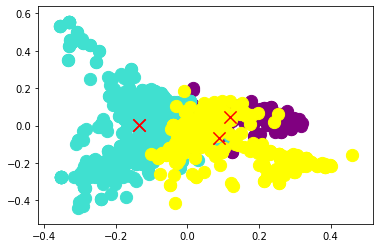

In [99]:
#ACP

acp = PCA(n_components=2).fit_transform(data_vect02.toarray())

plt.scatter(acp[:,0], acp[:,1], c=model02.predict(data_vect02))
acp_cluster_centers = pca.transform(model02.cluster_centers_)
for couleur,k in zip(['purple','turquoise','yellow'],[0,1,2]):
    plt.scatter(acp[model02.labels_==k,0],acp[model02.labels_==k,1],s=150,c=couleur)
    plt.scatter(acp_cluster_centers[:, 0], acp_cluster_centers[:,1], marker='x', s=150, c='red')
plt.show()

In [104]:
data02["texte"][ClusterIndicesNumpy(0, model02.labels_) ]

0       4. version desktop - liste cas d'utilisations ...
1                         4.1.1 cu001-001 afficher header
5        actions : si lutilisateur clique logo depui...
8       cas dutilisation permettant internaute consul...
10       actions : clic langue sélectionnée, système ...
14      cas dutilisation permettant internaute consul...
19                                                    NaN
22      cas dutilisation permettant internaute consul...
26                4.1.6 cu001-004 afficher bouton partage
28      cas dutilisation permettant internaute consul...
32               4.1.7 cu001-005 afficher menu navigation
34      cas dutilisation permettant internaute consul...
35       notes : menu constitué entrées niveau 1 : in...
37       règles gestion : si lutilisateur navigue la...
40       notes : lutilisateur peut créer lien niveau...
42                                                    NaN
45       4.1.10 cu001-008 contribuer contenu autre langue
48       note

In [102]:
data02.texte[ClusterIndicesNumpy(1, model02.labels_) ]

3       cas dutilisation permettant internaute consul...
4        notes : système affiche éléments suivants : ...
7                                                     NaN
12                  4.1.3 cu001-0021 afficher page langue
16                4.1.4 cu001-0022 contribuer page langue
17                                                    NaN
21                                                    NaN
30       actions : clic bouton partage, menu suppléme...
31       règles gestion depuis page éditorial titre p...
33                                                    NaN
41          4.1.9 cu001-007 afficher contenu autre langue
44       règles gestion : si lutilisateur a sélectio...
47      cas dutilisation permettant internaute contri...
52                                                    NaN
55       règles gestion : si lutilisateur ouvre nouv...
60                       4.1.13 cu001-011 afficher footer
64       actions : clic lien permet lutilisateur da...
71            

In [103]:
data02.texte[ClusterIndicesNumpy(2, model02.labels_) ]

2                                                     NaN
6                  4.1.2 cu001-002 afficher bouton langue
9        notes : système affiche : langue sélectionné...
11       règles gestion : si lutilisateur clique ang...
13                                                    NaN
15                                                    NaN
18                                                    NaN
20                  4.1.5 cu001-003 afficher fil dariane
23      fil dariane présent toutes pages permet luti...
24      fil dariane composé dun lien vers page dacc...
25       règles gestion fil dariane saffiche : page...
27                                                    NaN
29       notes : page cours consultation partagée com...
36       actions : clic lune entrées niveau 1 rubriq...
38               4.1.8 cu001-006 modifier menu navigation
39                                                    NaN
43      cas dutilisation permettant internaute consul...
46            